In [8]:
'''
for computing the grid resolution xsi:
- compute max distance between all points
- compute min distance between all points
- derive grid resolution by maxdist/mindist = number of intervals --> xsi param in ELKI
'''
import pandas as pd
from scipy.spatial.distance import cdist
import numpy as np

elki = "C:\\Users\\kazempour\\Desktop\\elki-0.7.1\\elki-bundle-0.7.1.jar"
datain = "C:\\Users\\kazempour\Desktop\\elki-0.7.1\\subspacetoy.csv"
resout = "C:\\Users\\kazempour\\Desktop\\elki-0.7.1\\cliquerestest"


def get_xsi_estimate(infile):
    #read csv file and convert it to list of coordinates
    data = pd.read_csv(infile, delimiter=",")
    tolist = data.values.tolist()
    
    #compute pairwise dist:
    pairwdist = cdist(tolist, tolist)
    
    #set diagonal to +inf
    np.fill_diagonal(pairwdist, np.inf)
    #get min distance
    min_value = pairwdist.min()
    
    
    #set diagonal to -inf
    np.fill_diagonal(pairwdist, -np.inf)
    #get max distance
    max_value = pairwdist.max()
    
    #compute ratio max/min = xsi
    xsi = 0
    if int(min_value) == 0:
        min_value = 1
    xsi = max_value/min_value
    
    if(type(xsi)==float):
        return int(xsi)
    else:
        return xsi
    
    
get_xsi_estimate(datain)

185.4588903234353

In [37]:
import subprocess
import os
import itertools
from time import sleep



xsirange = np.linspace(1.0, get_xsi_estimate(datain), dtype = int, num=10) 
taurange = np.linspace(0.01, 0.99, num=10)

print(taurange)
print(xsirange)

[0.01       0.11888889 0.22777778 0.33666667 0.44555556 0.55444444
 0.66333333 0.77222222 0.88111111 0.99      ]
[  1  21  41  62  82 103 123 144 164 185]


In [ ]:


'''
Function takes the following parameters and executes the CLIQUE algorithm in ELKI:
path2elki: path to the single all-in-one ELKI jar file, get it from: 
https://elki-project.github.io/releases/release0.7.1/elki-bundle-0.7.1.jar

path2data: full path to the csv (input) file
as the output it generates a folder with the cluster files
'''
def elki_run_clique(path2elki, path2data, path2out, xsi, tau):
    process = subprocess.Popen('java -jar '+path2elki+' KDDCLIApplication     -dbc.in '+path2data+'     -time     -algorithm clustering.subspace.CLIQUE     -clique.xsi '+str(xsi)+'     -clique.tau '+str(tau)+'   -clique.prune    -resulthandler ResultWriter     -out '+path2out+'')
    pid=str(process.pid)
    print("Elki job done with process id: ",pid)



xsi = 330
tau = 0.01
    
    
def cliqueres_pipeline(path2elki, path2data, path2out, xsirng, taurng):
    #create pairwise crossproduct between xsi and tau list --> elements on our parameter grid
    xsitautuples = list(itertools.product(xsirng, taurng))
    
    runid = 0
    for partuple in xsitautuples:
        xsi, tau = partuple
        print('RUNID: ',runid,' STARTING CLIQUE WITH XSI: ',xsi,' AND TAU: ',tau)
        resout = path2out+str(runid)
        elki_run_clique(path2elki, path2data, resout, xsi, tau)
        runid += 1
        sleep(1.0)

cliqueres_pipeline(elki, datain, resout, xsirange, taurange)


In [10]:
import numpy as np
import ast

'''
Routine to get all cluster_i.txt files from a result resout folder.
Supposed to extract the following values for each cluster_i.txt:
- subspaces [dim_j, dim_k ...]
- data points
- cluster mean
'''

def extract_res(cluster_i, clid):
    with open(cluster_i) as f:
        content = f.readlines()
        content = [x.strip() for x in content]
        
    #get mean entry after "# Cluster Mean:"
    meanstring = content[5].split(":",1)[1]
    #split string by ',' to get single values in an array
    meanstringsplitted = meanstring.split(',')
    #convert that array of string mean coordinates to float!
    mean_field = np.array(meanstringsplitted).astype(np.float)
    #print('Mean vector: ',mean_field)
    
    
    #get subspace entry after "Subspace: Dimensions:", 
    #strip is required to eliminate any spaces leading to "wrong indent" errors...
    subspacestring = (content[6].split(":")[2]).strip()
    #parse/evaluate an array in string form to an python array
    subspacestring2array = ast.literal_eval(subspacestring) 
    subspace_field = (np.array(subspacestring2array)).tolist()
    #print('Subspace vector: ',subspace_field)
    
    
    clustermembers = []
    for e in content:
        #check if it is a line containing a coordinate, indicated with "ID="
        if("ID=" in e):
            #split line by whitespace, discard first entry, this is the ID= stuff...
            coorvec = (np.array((e.split(" "))[1:]).astype(np.float)).tolist()
            clustermembers.append(coorvec)
    #print('coordinates: ',clustermembers)
    
    return (clid, mean_field, subspace_field, clustermembers)
        

#extract_res(resout+str(0)+'\\cluster_1.txt', 0)

In [11]:
'''
Function iterates over all files in the specified path2out (output folder of ELKI)
and returns a dictionary which assigns for each cluster file a cluster id as key
and as value the list with the equation of the linear function and data points belonging to the cluster
'''
def get_all_results(path2out):
    #all clusters are stored in a dictionary with the structure:
    #key: cluster_id, mean vector, subspaces, clustermembers
    clusdict = {}
    
    directory = os.fsencode(path2out)

    clid = 0
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if "cluster" in filename: 
            #print(filename)
            clusdict[clid] = extract_res(path2out+'\\'+filename, clid)
            clid+=1
    
    return clusdict

#uncomment line below to test functionality
#gres = get_all_results(resout+str(df.loc[1,0.01]))
#print(gres[0][3])

xsitautuples = list(itertools.product(xsirange, taurange))    
#lookup table for the file names, the rows and columns position reveals the filename number/id
dflookup = pd.DataFrame(np.reshape(np.arange(0,len(xsirange)*len(taurange)),(len(xsirange),len(taurange))), index=xsirange, columns=taurange)
print(dflookup)
#dflookup.loc[62,0.01]


def extract_setofcluster(path2out, xsi, tau, lookupframe):
    allres = get_all_results(path2out+str(lookupframe.loc[xsi,tau]))
    clusterslis = []
    subspacelis = []
    for key in allres:
        data = (allres[key])[3]
        subsp = (allres[key])[2]
        clusterslis.append(data)
        subspacelis.append(subsp)
        
    return (clusterslis,subspacelis)
        
print(extract_setofcluster(resout, 1, 0.01, dflookup))
#print(dflookup.columns)
#print(taurange)

     0.010000  0.118889  0.227778  0.336667  0.445556  0.554444  0.663333  \
1           0         1         2         3         4         5         6   
21         10        11        12        13        14        15        16   
41         20        21        22        23        24        25        26   
62         30        31        32        33        34        35        36   
82         40        41        42        43        44        45        46   
103        50        51        52        53        54        55        56   
123        60        61        62        63        64        65        66   
144        70        71        72        73        74        75        76   
164        80        81        82        83        84        85        86   
185        90        91        92        93        94        95        96   

     0.772222  0.881111  0.990000  
1           7         8         9  
21         17        18        19  
41         27        28        29  
62      

In [12]:
'''
handwritten function which compares two lists of coordinates and returns the intersecting set
since python is such a mimimimimimimimimi fucked up language not capable of the most simple thing:
to get the fucking intersection of two lists of coordinates ...that's all - nothing but this
a basic fucking tasks which is not any exotic bullshit function like np has plenty of this shit.
'''
def intersectbetween(locoor1, locoor2):
    intersectlis = []
    
    for e in locoor1:
        if e in locoor2:
            intersectlis.append(e)
    
    #that's it...why is such a simple bloody function not implemented as a standard????
    return intersectlis




'''
function takes two sets of sets(=clusters) of datapoints
and returns those set of sets whose intersection count is max

it shall be applied also on the set of sets of subspace-id's 
'''
def get_max_intersect_set(predsuperset, succsuperset):
    currwinintersect = {}
    currwinsubspace = []
    
    intersecttaskset = list(itertools.product(predsuperset[0], succsuperset[0]))
    intersectsubspace = list(itertools.product(predsuperset[1], succsuperset[1]))
    subspaceindex = 0
    #print(intersectsubspace)
    for e in intersecttaskset:
        set1, set2 = e
        interset = intersectbetween(set1,set2)#set(set1).intersection(set(set2))
        if len(interset) > len(currwinintersect):
            currwinintersect = interset
            currwinsubspace = intersectsubspace[subspaceindex]
        subspaceindex += 1
        
    return list(currwinintersect),list(currwinsubspace)

#synth./toy example; inaccurate and shitty example
#get_max_intersect_set([[1,2,3,4],[5,6]],[[3,4,5],[6,7,8]])

#real example
firstrunclusters = extract_setofcluster(resout, 1, 0.01, dflookup)
secondrunclusters = extract_setofcluster(resout, 21, 0.11888888888888888, dflookup)
thirdrunclusters = extract_setofcluster(resout, 1, 0.11888888888888888, dflookup)
fourthrunclusters = extract_setofcluster(resout, 21, 0.01, dflookup)
#for e in firstrunclusters:
 #   print(e)
(get_max_intersect_set(firstrunclusters, secondrunclusters)[1])

[[1], [3]]

In [13]:
'''
glob.var:
- dflookup
- xsirange: i
- taurange: j
'''

'''
auxillary function for dynamic-programming-ish 
computation of "optimal" parameter path
maximising for an intersection cardinality
'''
def get_next_maxintersect(i,j,param1lis, param2lis, parlookupmx, path2out, sourceintersectset):
    #retrieve row and column and thus xsi and tau values from i,j
    xsi = param1lis[i]
    tau = param2lis[j]
    
    #now we got here a dictionary for the target (i,j) and three of its adjacent parameter (xsi,tau)tuples
    #containing the intersected clusters
    clusdict = {'0,0': extract_setofcluster(path2out, param1lis[i], param2lis[j], parlookupmx),
                '0,1': extract_setofcluster(path2out, param1lis[i], param2lis[j+1], parlookupmx),
                '1,0': extract_setofcluster(path2out, param1lis[i+1], param2lis[j], parlookupmx),
                '1,1': extract_setofcluster(path2out, param1lis[i+1], param2lis[j+1], parlookupmx)}
    
    #retrieve the folder from which the clusters can be retrieved
    #having now the data, we proceed with the computation of the maximum intersection
    maxdict = {'[[0,0],[0,1]]': get_max_intersect_set(sourceintersectset, clusdict['0,1']),
              '[[0,0],[1,0]]': get_max_intersect_set(sourceintersectset, clusdict['1,0']),
              '[[0,0],[1,1]]': get_max_intersect_set(sourceintersectset, clusdict['1,1'])}
    
    
    #print('MAXDICT: ',maxdict,' END')
    maxcard = 0
    maxcandset = []
    maxcandidx = []
    for key in maxdict:
        #print('KEY: ',key,' MAXDICT SET: ',maxdict[key])
        intersize = len((maxdict[key])[0])
        if intersize >= maxcard:
            maxcard = intersize
            maxcandset = maxdict[key]
            maxcandidx = key
        
    return (maxcard, maxcandset, maxcandidx)

sourceset = extract_setofcluster(resout, xsirange[0], taurange[0], dflookup)
sourceset1 = ([[[80.0, 107.0, 123.0], [81.0, 109.0, 124.0], [81.0, 108.0, 123.0], [84.0, 109.0, 123.0], [82.0, 105.0, 125.0], [84.0, 106.0, 123.0], [80.0, 105.0, 126.0], [80.0, 108.0, 123.0], [84.0, 108.0, 124.0], [84.0, 109.0, 127.0], [82.0, 108.0, 126.0], [81.0, 109.0, 120.0], [80.0, 106.0, 124.0], [81.0, 108.0, 123.0], [81.0, 109.0, 127.0], [83.0, 108.0, 121.0], [83.0, 105.0, 125.0], [83.0, 108.0, 127.0], [80.0, 107.0, 125.0], [81.0, 106.0, 124.0], [80.0, 108.0, 129.0], [80.0, 107.0, 122.0], [81.0, 106.0, 125.0], [81.0, 106.0, 128.0], [83.0, 106.0, 123.0], [82.0, 106.0, 123.0], [84.0, 105.0, 125.0], [81.0, 108.0, 128.0], [83.0, 106.0, 127.0], [84.0, 105.0, 126.0], [83.0, 107.0, 122.0], [81.0, 106.0, 122.0], [84.0, 106.0, 121.0], [80.0, 107.0, 126.0], [81.0, 109.0, 121.0], [84.0, 108.0, 123.0], [83.0, 107.0, 126.0], [81.0, 105.0, 128.0], [81.0, 109.0, 123.0], [80.0, 107.0, 126.0], [83.0, 107.0, 121.0], [82.0, 108.0, 121.0], [82.0, 105.0, 122.0], [83.0, 107.0, 120.0], [84.0, 109.0, 126.0], [81.0, 106.0, 120.0], [81.0, 108.0, 128.0], [84.0, 105.0, 127.0], [83.0, 109.0, 123.0], [80.0, 109.0, 125.0], [39.0, 92.0, 28.0], [29.0, 90.0, 25.0], [20.0, 95.0, 29.0], [32.0, 99.0, 22.0], [33.0, 98.0, 27.0], [36.0, 90.0, 22.0], [37.0, 92.0, 22.0], [39.0, 99.0, 23.0], [3.0, 4.0, 2.0], [4.0, 32.0, 2.0], [1.0, 1.0, 2.0], [0.0, 22.0, 2.0], [7.0, 1.0, 2.0], [4.0, 20.0, 2.0], [6.0, 21.0, 2.0], [3.0, 23.0, 2.0], [0.0, 16.0, 2.0], [2.0, 16.0, 2.0], [8.0, 30.0, 2.0], [3.0, 2.0, 2.0], [3.0, 30.0, 2.0], [2.0, 10.0, 2.0], [3.0, 23.0, 2.0], [8.0, 26.0, 2.0], [9.0, 15.0, 2.0], [9.0, 12.0, 2.0], [1.0, 0.0, 2.0], [4.0, 38.0, 2.0]]], [[1], [1]])
#print(sourceset)
#for e in sourceset:
#    print('E: ',e)

res = get_next_maxintersect(0,1,xsirange,taurange,dflookup,resout, sourceset1)
print(res)

(78, ([[80.0, 107.0, 123.0], [81.0, 109.0, 124.0], [81.0, 108.0, 123.0], [84.0, 109.0, 123.0], [82.0, 105.0, 125.0], [84.0, 106.0, 123.0], [80.0, 105.0, 126.0], [80.0, 108.0, 123.0], [84.0, 108.0, 124.0], [84.0, 109.0, 127.0], [82.0, 108.0, 126.0], [81.0, 109.0, 120.0], [80.0, 106.0, 124.0], [81.0, 108.0, 123.0], [81.0, 109.0, 127.0], [83.0, 108.0, 121.0], [83.0, 105.0, 125.0], [83.0, 108.0, 127.0], [80.0, 107.0, 125.0], [81.0, 106.0, 124.0], [80.0, 108.0, 129.0], [80.0, 107.0, 122.0], [81.0, 106.0, 125.0], [81.0, 106.0, 128.0], [83.0, 106.0, 123.0], [82.0, 106.0, 123.0], [84.0, 105.0, 125.0], [81.0, 108.0, 128.0], [83.0, 106.0, 127.0], [84.0, 105.0, 126.0], [83.0, 107.0, 122.0], [81.0, 106.0, 122.0], [84.0, 106.0, 121.0], [80.0, 107.0, 126.0], [81.0, 109.0, 121.0], [84.0, 108.0, 123.0], [83.0, 107.0, 126.0], [81.0, 105.0, 128.0], [81.0, 109.0, 123.0], [80.0, 107.0, 126.0], [83.0, 107.0, 121.0], [82.0, 108.0, 121.0], [82.0, 105.0, 122.0], [83.0, 107.0, 120.0], [84.0, 109.0, 126.0], [81

In [46]:
def dynamic_intersect_computing(param1lis, param2lis, parlookupmx, path2out):
    i = 1 #0
    j = 0
    
    targetdict = {'[[0,0],[0,1]]' : (0,1),
                 '[[0,0],[1,0]]' : (1,0),
                 '[[0,0],[1,1]]' : (1,1)}
    
    reslis = []
    
    sourceset = extract_setofcluster(path2out, param1lis[i], param2lis[j], parlookupmx)
    res = get_next_maxintersect(i,j,param1lis,param2lis,parlookupmx,path2out,sourceset)
    reslis.append(res)
    
    print('------------------INITSET---------------------')
    #print(res)
    print('-----------------ENDINITSET-------------------')
    
    while(res[0] > 0) and (i<len(param1lis)-2 and j<len(param2lis)-2):
        
        #extracting cardinality of intersection set
        lastappended = reslis[-1]
        
        #extracting  and re-assigning indices idx
        extracted_chosen_target_idx = (lastappended[2])
        i_incr, j_incr = targetdict[extracted_chosen_target_idx]
        i = i + i_incr
        j = j + j_incr
        print('I: ',i,' J: ',j)
        
        badformat_sourceset, badformat_next = lastappended[1]
        sourceset = ([badformat_sourceset],badformat_next)
        #print('SOURCE: ',sourceset)
        res = get_next_maxintersect(i,j, param1lis, param2lis, parlookupmx, path2out, sourceset)
        #print('RES: ',res)
        reslis.append(res)
    
    return reslis
        
        
dynlis = dynamic_intersect_computing(xsirange, taurange, dflookup, resout)
for e in dynlis:
    print(e)
    print('---------')

------------------INITSET---------------------
-----------------ENDINITSET-------------------
I:  2  J:  1
I:  2  J:  2
I:  3  J:  2
I:  4  J:  2
I:  5  J:  2
(50, ([[80.0, 107.0, 123.0], [81.0, 109.0, 124.0], [81.0, 108.0, 123.0], [84.0, 109.0, 123.0], [82.0, 105.0, 125.0], [84.0, 106.0, 123.0], [80.0, 105.0, 126.0], [80.0, 108.0, 123.0], [84.0, 108.0, 124.0], [84.0, 109.0, 127.0], [82.0, 108.0, 126.0], [81.0, 109.0, 120.0], [80.0, 106.0, 124.0], [81.0, 108.0, 123.0], [81.0, 109.0, 127.0], [83.0, 108.0, 121.0], [83.0, 105.0, 125.0], [83.0, 108.0, 127.0], [80.0, 107.0, 125.0], [81.0, 106.0, 124.0], [80.0, 108.0, 129.0], [80.0, 107.0, 122.0], [81.0, 106.0, 125.0], [81.0, 106.0, 128.0], [83.0, 106.0, 123.0], [82.0, 106.0, 123.0], [84.0, 105.0, 125.0], [81.0, 108.0, 128.0], [83.0, 106.0, 127.0], [84.0, 105.0, 126.0], [83.0, 107.0, 122.0], [81.0, 106.0, 122.0], [84.0, 106.0, 121.0], [80.0, 107.0, 126.0], [81.0, 109.0, 121.0], [84.0, 108.0, 123.0], [83.0, 107.0, 126.0], [81.0, 105.0, 128.0]

In [15]:


#all tau, xsi param combinations in parameter range
xsitautuples = list(itertools.product(xsirange, taurange))




def get_paramgrid_stats(path2out, paramtuples):
    paramdict = {}
    runind = 0

    for e in xsitautuples:
        clusdict = get_all_results(path2out+str(runind))
    
        dptcountlis = []
        subspacecountlis = []
        clustercounter = 0
    
        for key in clusdict:
            clid, mean_field, subspace_field, clustermembers = clusdict[key]
            dptcountlis.append(len(clustermembers))
            subspacecountlis.append(len(subspace_field))
            clustercounter += 1 
    
        if key not in clusdict:
            dptcountlis = [0]
            subspacecountlis = [0]
    
        paramdict[e] = [clustercounter, np.average(dptcountlis), np.average(subspacecountlis)]
        runind += 1
    
    return paramdict

paradict = get_paramgrid_stats(resout, xsitautuples)

idx = 0
for key in paradict:
    print('IDX: ',idx,' KEY: ',key,' VAL: ',paradict[key])
    idx+=1

IDX:  0  KEY:  (1, 0.01)  VAL:  [7, 78.0, 1.7142857142857142]
IDX:  1  KEY:  (1, 0.11888888888888888)  VAL:  [7, 78.0, 1.7142857142857142]
IDX:  2  KEY:  (1, 0.22777777777777777)  VAL:  [7, 78.0, 1.7142857142857142]
IDX:  3  KEY:  (1, 0.33666666666666667)  VAL:  [7, 78.0, 1.7142857142857142]
IDX:  4  KEY:  (1, 0.44555555555555554)  VAL:  [7, 78.0, 1.7142857142857142]
IDX:  5  KEY:  (1, 0.5544444444444444)  VAL:  [7, 78.0, 1.7142857142857142]
IDX:  6  KEY:  (1, 0.6633333333333333)  VAL:  [7, 78.0, 1.7142857142857142]
IDX:  7  KEY:  (1, 0.7722222222222221)  VAL:  [7, 78.0, 1.7142857142857142]
IDX:  8  KEY:  (1, 0.8811111111111111)  VAL:  [7, 78.0, 1.7142857142857142]
IDX:  9  KEY:  (1, 0.99)  VAL:  [7, 78.0, 1.7142857142857142]
IDX:  10  KEY:  (21, 0.01)  VAL:  [31, 17.612903225806452, 1.967741935483871]
IDX:  11  KEY:  (21, 0.11888888888888888)  VAL:  [10, 37.8, 1.6]
IDX:  12  KEY:  (21, 0.22777777777777777)  VAL:  [8, 35.5, 1.625]
IDX:  13  KEY:  (21, 0.33666666666666667)  VAL:  [7, 37

In [33]:

tuplelis = []
for key in paradict:
    xsi, tau = key
    count, avgdpt, avgsub = paradict[key]
    tuplelis.append((xsi, tau, count, avgdpt, avgsub))
    

%matplotlib qt
from matplotlib.patches import Rectangle

#def plot_param_against()
xsi, tau, count, avgdpt, avgsub = zip(*tuplelis)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

ax = plt.gca(projection="3d")
ax.scatter(xsi,tau,count, color='r', label = 'number of merging clusters')
ax.scatter(xsi,tau,avgdpt, color='g', label = 'average number of data points per cluster')
ax.scatter(xsi,tau,avgsub, color='b', label = 'average number of subspaces per cluster')
#ax.set_zlim3d(0,10)

ax.set_xlabel('xsi')
ax.set_ylabel('tau')
ax.set_zlabel('count and average (see legend)')
ax.legend()

plt.show()

In [45]:
'''
just plotting the original data....
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib qt

df = pd.read_csv('subspacetoy.csv')
listdf = df.values.tolist()
label, x, y, z = list(zip(*listdf))
ax = plt.gca(projection="3d")
ax.scatter(x,y,z, color='r')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()



In [30]:
%matplotlib qt
import matplotlib.pyplot as plt
years = [i for i in range(1985, 2019, 1)]
numpub = [1,1,0,0,1,0,2,1,1,0,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,2,0,2,3,4,2,8,33,101]
plt.plot(years,numpub,'-o')
plt.xlabel('Year')
plt.ylabel('Number of publications')
plt.show()

In [2]:
'''
read sample toy example and plot it!
'''
xp = []
yp = []
zp = []

import csv
with open('C:\\Users\\kazempour\Desktop\\elki-0.7.1\\subspacetoy.csv', 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        xp.append(float(row[0]))
        yp.append(float(row[1]))
        zp.append(float(row[2]))
        
print(xp)

[4.0, 1.0, 9.0, 9.0, 8.0, 3.0, 2.0, 3.0, 3.0, 8.0, 2.0, 0.0, 3.0, 6.0, 4.0, 7.0, 0.0, 1.0, 4.0, 3.0, 39.0, 37.0, 36.0, 33.0, 32.0, 20.0, 29.0, 39.0, 80.0, 83.0, 84.0, 81.0, 81.0, 84.0, 83.0, 82.0, 82.0, 83.0, 80.0, 81.0, 81.0, 83.0, 84.0, 81.0, 80.0, 84.0, 81.0, 83.0, 84.0, 83.0, 81.0, 84.0, 82.0, 83.0, 81.0, 81.0, 80.0, 80.0, 81.0, 80.0, 83.0, 83.0, 83.0, 81.0, 81.0, 80.0, 81.0, 82.0, 84.0, 84.0, 80.0, 80.0, 84.0, 82.0, 84.0, 81.0, 81.0, 80.0]


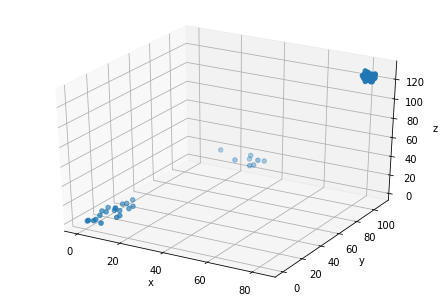

In [5]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random


fig = pyplot.figure()
ax = Axes3D(fig)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.scatter(xp, yp, zp)
pyplot.show()